*Name*: Soumil

Development environment (Colab or local): Colab

# Deep Learning Analysis

- **Tasks:** 
  1. Compare the performance of a small CNN (LeNet-5) with the results you got for PCA, LDA, and SVM using the Olivetti faces dataset
  2. Choose, implement (if not available in a library),  and run a baseline for the IMDB text classification from lecture
    - Consider what techniques would be appropriate for this task.
    - Also consider the fact that this is a text dataset, so some techniques might not work well or may be cumbersome to engineer.
    - Include a description of your baseline and explain why this baseline makes sense for this problem.
  3. Run a vanilla RNN on the IMDB text classification dataset and compare its performance against your baseline.
  4. Explore data augmentation techniques for both tasks.
    - For the image task, you may use the built-in Keras data augmentation function (tf.keras.preprocessing.image.ImageDataGenerator).
    - For the text task, you may find an external function that you import or write your own data augmentation.
    - Describe what data augmentation methods you used and the motivation behind them (why you think they'll help).

_Where it is relevant, make sure you follow deep learning best practices. In particular, performing a hyperparameter search and setting up an proper train, dev, and test framework for evaluating hyperparameters and your final selected model._

- Evaluation scenarios:
  1. Facial Recognition
    - Use 20% of the images for training and 80% for testing
    - Use 50% of the images for training and 50% for testing
    - Use 80% of the images for training and 20% for testing
    - Always use the first K images per person for training, and the remaining ones for testing (see data split code below)
    - Plot CMC curve and confusion matrix for each combination of scenario

  2. Review Text Classification
    - Use 2,000 examples for training and 2,000 examples for testing (smaller than the example in lecture)
    - Experiment with several RNN configurations
    - Plot the training and validation plots for your RNN and for your baseline if your baseline has a training phase.
    - Plot a confusion matrix of the predictions.



## Olivetti faces dataset (AT&T Laboratories Cambridge)

As described on the original website:

"*There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).*"

The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

- Classes: 40
- Samples per class: 10
- Samples total: 400
- Dimensionality: 4096 (64x64 pixels)
- Pixel values: real, between 0 and 1


In [132]:
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import tensorflow_datasets
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
!pip install textaugment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 1.5 MB 9.6 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15735 sha256=2cf285698937679c331b4285e9164abd5f92ae823d21503141c01919b863cd8e
  Stored in directory: /root/.cache/pip/wheels/0e/ce/9b/d51de1064911d42480ab6b57fc943ee36572441f27546354e2
Successfully built googletrans


# Get the dataset

In [29]:
faces = fetch_olivetti_faces()

_, img_height, img_width = faces.images.shape

print(faces.images.shape)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
(400, 64, 64)


# Split the dataset

In [112]:
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
GALLERY_SIZE = 2                            # use the first GALLERY_SIZE images per individual for training, the rest for testing

gallery_indices = []
probe_indices = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices += indices[:GALLERY_SIZE]
  probe_indices += indices[GALLERY_SIZE:]

x_train = faces.images[gallery_indices].reshape(-1, img_height, img_width, 1)
y_train = faces.target[gallery_indices]
x_test = faces.images[probe_indices].reshape(-1, img_height, img_width, 1)
y_test = faces.target[probe_indices]


print(x_train.shape, x_test.shape)

(80, 64, 64, 1) (320, 64, 64, 1)


In [113]:
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
GALLERY_SIZE = 5                            # use the first GALLERY_SIZE images per individual for training, the rest for testing

gallery_indices = []
probe_indices = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices += indices[:GALLERY_SIZE]
  probe_indices += indices[GALLERY_SIZE:]

x1_train = faces.images[gallery_indices].reshape(-1, img_height, img_width, 1)
y1_train = faces.target[gallery_indices]
x1_test = faces.images[probe_indices].reshape(-1, img_height, img_width, 1)
y1_test = faces.target[probe_indices]


print(x1_train.shape, x1_test.shape)

(200, 64, 64, 1) (200, 64, 64, 1)


In [114]:
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
GALLERY_SIZE = 8                            # use the first GALLERY_SIZE images per individual for training, the rest for testing

gallery_indices = []
probe_indices = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices += indices[:GALLERY_SIZE]
  probe_indices += indices[GALLERY_SIZE:]

x2_train = faces.images[gallery_indices].reshape(-1, img_height, img_width, 1)
y2_train = faces.target[gallery_indices]
x2_test = faces.images[probe_indices].reshape(-1, img_height, img_width, 1)
y2_test = faces.target[probe_indices]


print(x2_train.shape, x2_test.shape)

(320, 64, 64, 1) (80, 64, 64, 1)


# Visualize the splits

In [44]:
def show_images(imgs, num_rows, num_cols):
  assert len(imgs) == num_rows*num_cols

  for i in range(num_rows):
    row = None
    for j in range(num_cols):
      if row is None:
        row = imgs[i*num_cols+j].reshape(img_height, img_width)*255.0
      else:
        row = np.concatenate((row, imgs[i*num_cols+j].reshape(img_height, img_width)*255.0), axis=1)
    cv2_imshow(row)

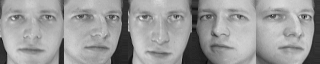

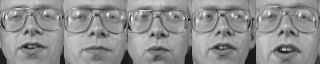

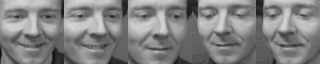

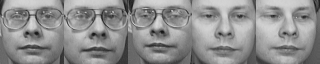

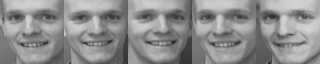

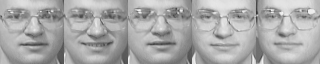

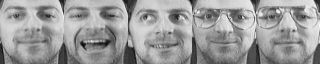

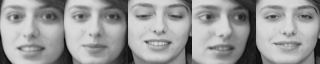

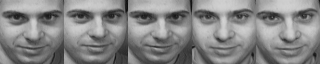

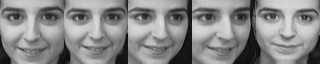

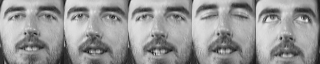

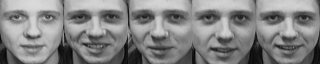

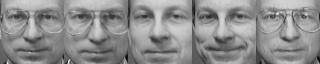

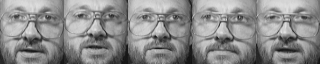

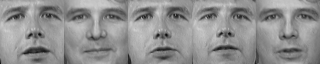

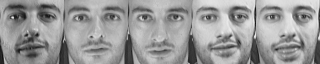

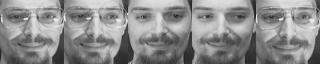

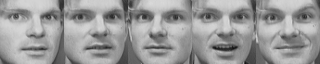

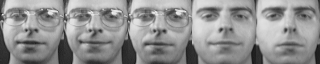

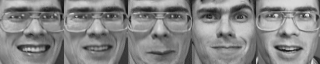

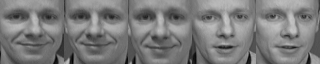

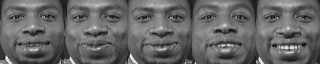

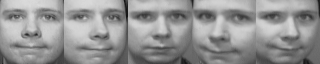

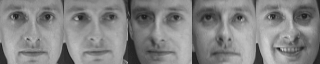

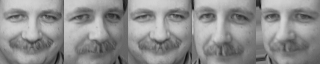

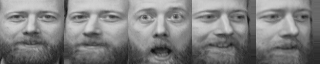

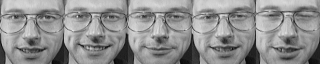

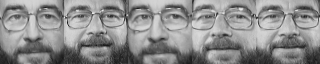

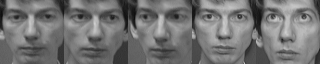

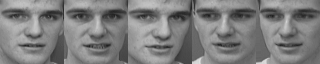

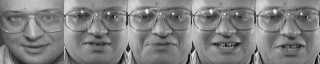

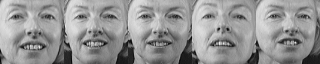

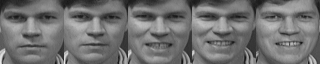

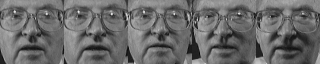

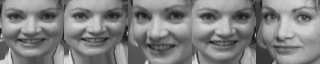

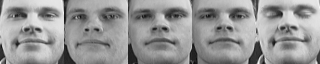

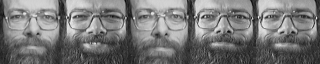

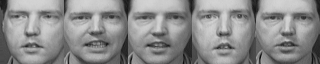

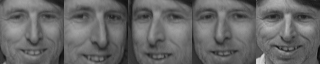

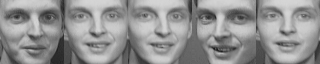

In [ ]:
show_images(x_train, N_IDENTITIES, GALLERY_SIZE)

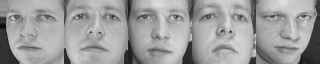

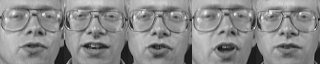

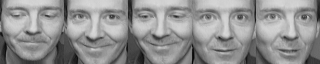

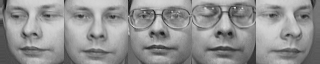

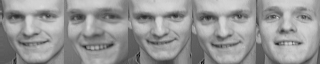

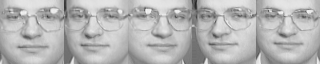

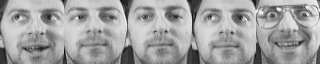

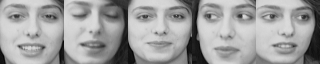

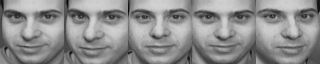

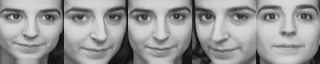

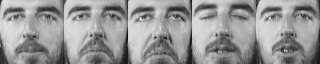

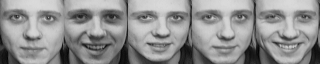

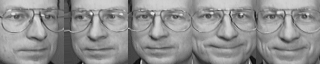

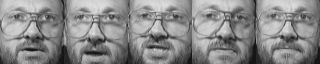

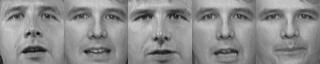

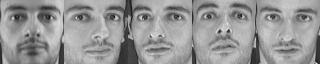

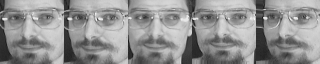

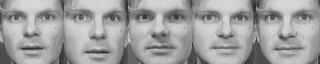

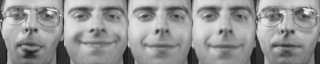

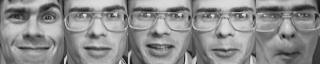

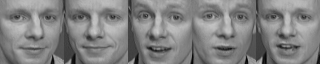

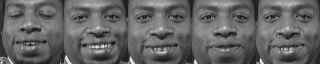

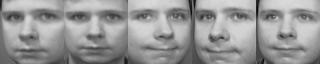

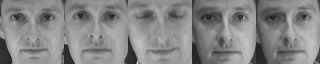

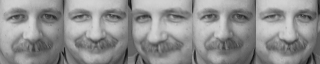

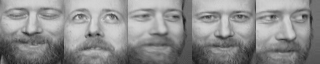

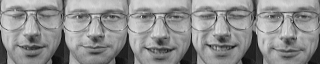

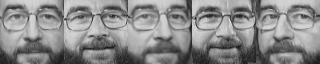

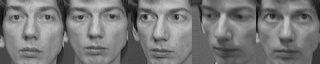

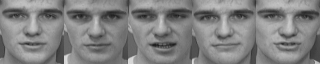

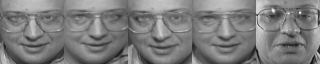

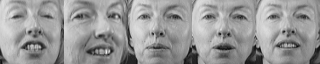

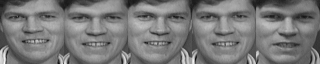

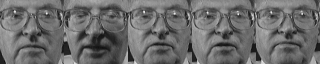

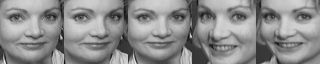

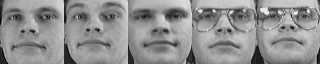

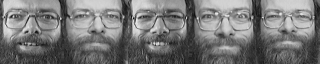

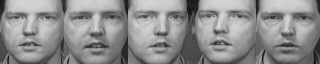

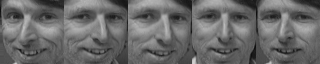

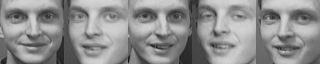

In [ ]:
show_images(x_test, N_IDENTITIES, 10 - GALLERY_SIZE)

# Run the experiments

Here is the code I used to get the results below!

# CNN (LeNet5)

Define learning rate, loss function, batch size, number of epochs, and how many times the model must be trained to obtain a reliable performance evaluation.

## Use 20% of the images for training and 80% for testing


In [115]:
shuffle = np.random.permutation(len(x_train))
check = int(0.30 * len(x_train))
x_val = x_train.take(shuffle[:check], axis=0)
x_train = x_train.take(shuffle[check:], axis=0)
y_val = y_train.take(shuffle[:check], axis=0)
y_train = y_train.take(shuffle[check:], axis=0)

In [116]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=120, activation='relu'),
    tf.keras.layers.Dense(units=84, activation='relu'),
    tf.keras.layers.Dense(units=40, activation = 'softmax')
])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 60, 60, 6)         156       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 30, 30, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 2704)              0         
                                                                 
 dense_39 (Dense)            (None, 120)             

In [117]:
learning_rate = 0.0005
loss_function = 'sparse_categorical_crossentropy'
batch_size = 20
num_epochs = 100

In [118]:
# training configuration
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=5, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='accuracy')

#train
history = model.fit(x=x_train,y=y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_test,y_test), callbacks=[early_stop, model_save])

Epoch 1/100
3/3 [==============================] - 2s 619ms/step - loss: 3.6972 - accuracy: 0.0357 - val_loss: 3.6902 - val_accuracy: 0.0219
Epoch 2/100
3/3 [==============================] - 1s 273ms/step - loss: 3.6766 - accuracy: 0.0357 - val_loss: 3.6905 - val_accuracy: 0.0437
Epoch 3/100
3/3 [==============================] - 1s 276ms/step - loss: 3.6648 - accuracy: 0.0714 - val_loss: 3.6929 - val_accuracy: 0.0250
Epoch 4/100
3/3 [==============================] - 1s 278ms/step - loss: 3.6547 - accuracy: 0.0357 - val_loss: 3.6964 - val_accuracy: 0.0250
Epoch 5/100
3/3 [==============================] - 1s 246ms/step - loss: 3.6415 - accuracy: 0.0357 - val_loss: 3.7004 - val_accuracy: 0.0250
Epoch 6/100
3/3 [==============================] - 1s 258ms/step - loss: 3.6341 - accuracy: 0.0536 - val_loss: 3.7067 - val_accuracy: 0.0500
Epoch 7/100
3/3 [==============================] - 1s 260ms/step - loss: 3.6199 - accuracy: 0.0714 - val_loss: 3.7050 - val_accuracy: 0.0500
Epoch 8/100
3

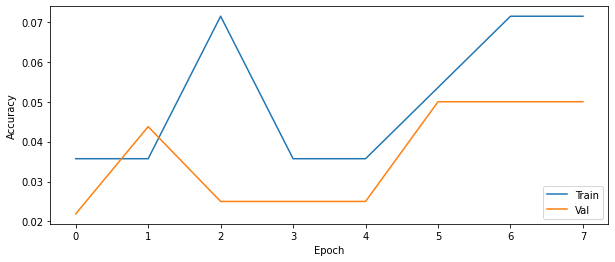

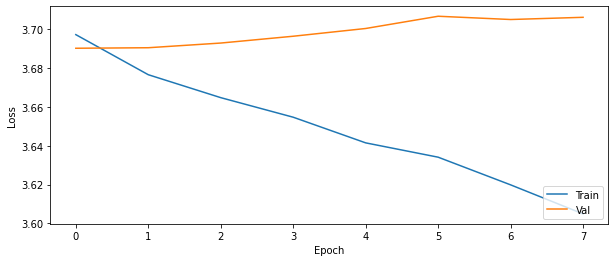

TRAINING SET
Loss: 3.5888748168945312 
Accuracy: 0.0714285746216774

TEST SET
Loss: 3.706141233444214 
Accuracy: 0.05000000074505806


In [119]:

# Define plot size
plt.rcParams["figure.figsize"] = (10,4)

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x_train, y_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_test, y_test, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

## Use 50% of the images for training and 50% for testing


In [120]:
check = int(0.30 * len(x1_train))

shuffle = np.random.permutation(len(x1_train))

x1_val = x1_train.take(shuffle[:check], axis=0)
x1_train = x1_train.take(shuffle[check:], axis=0)
y1_val = y1_train.take(shuffle[:check], axis=0)
y1_train = y1_train.take(shuffle[check:], axis=0)

In [121]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=120, activation='relu'),
    tf.keras.layers.Dense(units=84, activation='relu'),
    tf.keras.layers.Dense(units=40, activation = 'softmax')
])
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 60, 60, 6)         156       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 30, 30, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 2704)              0         
                                                                 
 dense_42 (Dense)            (None, 120)             

In [122]:
learning_rate = 0.0005
loss_function = 'sparse_categorical_crossentropy'
batch_size = 20
num_epochs = 100

optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=5, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='accuracy')
history = model.fit(x=x1_train,y=y1_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x1_test,y1_test), callbacks=[early_stop, model_save])

Epoch 1/100
7/7 [==============================] - 1s 139ms/step - loss: 3.7030 - accuracy: 0.0214 - val_loss: 3.6822 - val_accuracy: 0.0250
Epoch 2/100
7/7 [==============================] - 1s 107ms/step - loss: 3.6769 - accuracy: 0.0357 - val_loss: 3.6816 - val_accuracy: 0.0300
Epoch 3/100
7/7 [==============================] - 1s 110ms/step - loss: 3.6677 - accuracy: 0.0357 - val_loss: 3.6791 - val_accuracy: 0.0500
Epoch 4/100
7/7 [==============================] - 1s 109ms/step - loss: 3.6536 - accuracy: 0.0571 - val_loss: 3.6759 - val_accuracy: 0.0500
Epoch 5/100
7/7 [==============================] - 1s 107ms/step - loss: 3.6378 - accuracy: 0.0571 - val_loss: 3.6669 - val_accuracy: 0.0550
Epoch 6/100
7/7 [==============================] - 1s 111ms/step - loss: 3.6177 - accuracy: 0.0571 - val_loss: 3.6575 - val_accuracy: 0.0500
Epoch 7/100
7/7 [==============================] - 1s 106ms/step - loss: 3.5915 - accuracy: 0.0357 - val_loss: 3.6474 - val_accuracy: 0.0250
Epoch 8/100
7

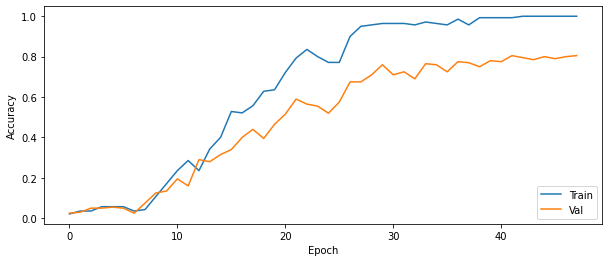

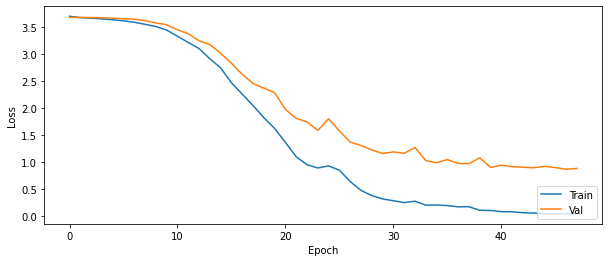

TRAINING SET
Loss: 0.033989038318395615 
Accuracy: 1.0

TEST SET
Loss: 0.8846485018730164 
Accuracy: 0.8050000071525574


In [123]:
plt.rcParams["figure.figsize"] = (10,4)

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x1_train, y1_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x1_test, y1_test, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

## Use 80% of the images for training and 20% for testing

In [124]:
check = int(0.20 * len(x2_train))
print(check)
shuffle = np.random.permutation(len(x2_train))

x2_val = x2_train.take(shuffle[:check], axis=0)
x2_train = x2_train.take(shuffle[check:], axis=0)
y2_val = y2_train.take(shuffle[:check], axis=0)
y2_train = y2_train.take(shuffle[check:], axis=0)

64


In [125]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=120, activation='relu'),
    tf.keras.layers.Dense(units=84, activation='relu'),
    tf.keras.layers.Dense(units=40, activation = 'softmax')
])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 60, 60, 6)         156       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 30, 30, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 2704)              0         
                                                                 
 dense_45 (Dense)            (None, 120)             

In [126]:
learning_rate = 0.0005
loss_function = 'sparse_categorical_crossentropy'
batch_size = 20
num_epochs = 100

optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=5, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='accuracy')
history = model.fit(x=x2_train,y=y2_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x2_test,y2_test), callbacks=[early_stop, model_save])

Epoch 1/100
13/13 [==============================] - 2s 90ms/step - loss: 3.6882 - accuracy: 0.0273 - val_loss: 3.6794 - val_accuracy: 0.0250
Epoch 2/100
13/13 [==============================] - 1s 76ms/step - loss: 3.6618 - accuracy: 0.0391 - val_loss: 3.6614 - val_accuracy: 0.0625
Epoch 3/100
13/13 [==============================] - 1s 76ms/step - loss: 3.6311 - accuracy: 0.0703 - val_loss: 3.6309 - val_accuracy: 0.0500
Epoch 4/100
13/13 [==============================] - 1s 75ms/step - loss: 3.5640 - accuracy: 0.1406 - val_loss: 3.5556 - val_accuracy: 0.1750
Epoch 5/100
13/13 [==============================] - 1s 75ms/step - loss: 3.4529 - accuracy: 0.1758 - val_loss: 3.4526 - val_accuracy: 0.2250
Epoch 6/100
13/13 [==============================] - 1s 74ms/step - loss: 3.2717 - accuracy: 0.2578 - val_loss: 3.2758 - val_accuracy: 0.1500
Epoch 7/100
13/13 [==============================] - 1s 75ms/step - loss: 3.0013 - accuracy: 0.3281 - val_loss: 3.0048 - val_accuracy: 0.3375
Epoch 

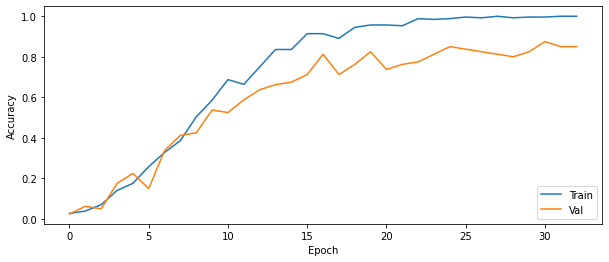

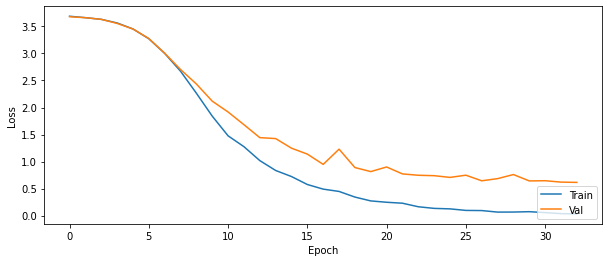

TRAINING SET
Loss: 0.026359980925917625 
Accuracy: 1.0

TEST SET
Loss: 0.6149566173553467 
Accuracy: 0.8500000238418579


In [127]:
plt.rcParams["figure.figsize"] = (10,4)

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Val'], loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Val'], loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x2_train, y2_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x2_test, y2_test, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

# CNN LeNet-5 with Data Augmentation

## Use 20% of the images for training and 80% for testing

Epoch 1/100
8/8 [==============================] - 2s 129ms/step - loss: 3.6906 - accuracy: 0.2750 - val_loss: 1.9017 - val_accuracy: 0.6000
Epoch 2/100
8/8 [==============================] - 1s 95ms/step - loss: 3.2171 - accuracy: 0.3500 - val_loss: 1.4685 - val_accuracy: 0.6500
Epoch 3/100
8/8 [==============================] - 1s 92ms/step - loss: 2.2082 - accuracy: 0.4500 - val_loss: 1.6521 - val_accuracy: 0.6000
Epoch 4/100
8/8 [==============================] - 1s 82ms/step - loss: 2.6973 - accuracy: 0.3562 - val_loss: 1.6912 - val_accuracy: 0.6000
Epoch 5/100
8/8 [==============================] - 1s 86ms/step - loss: 2.6217 - accuracy: 0.3688 - val_loss: 1.5769 - val_accuracy: 0.6000
Epoch 5: early stopping


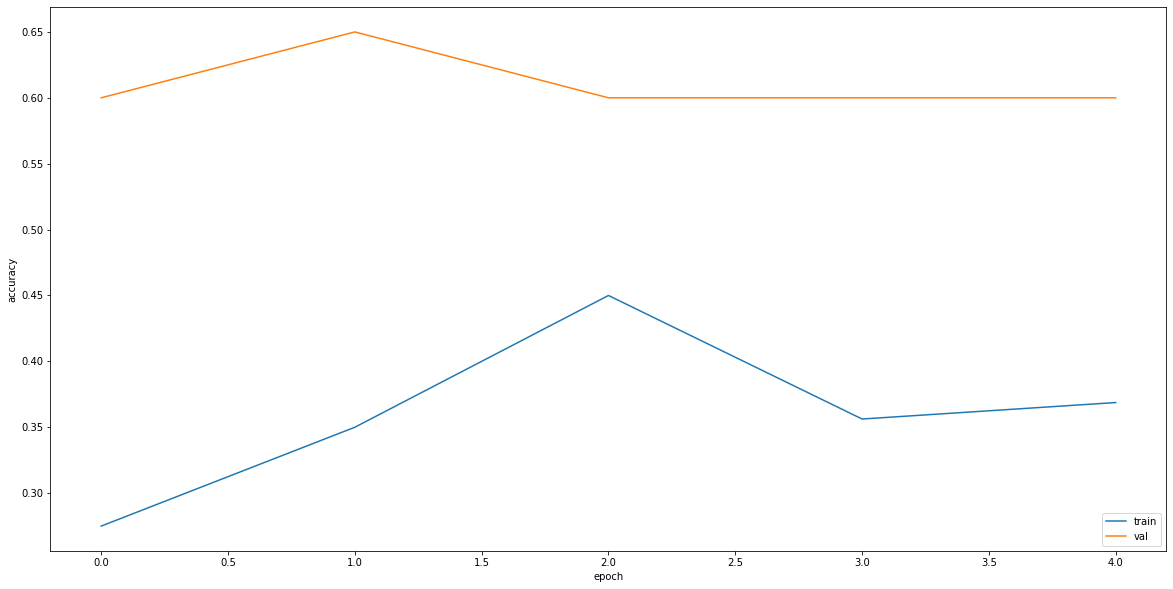

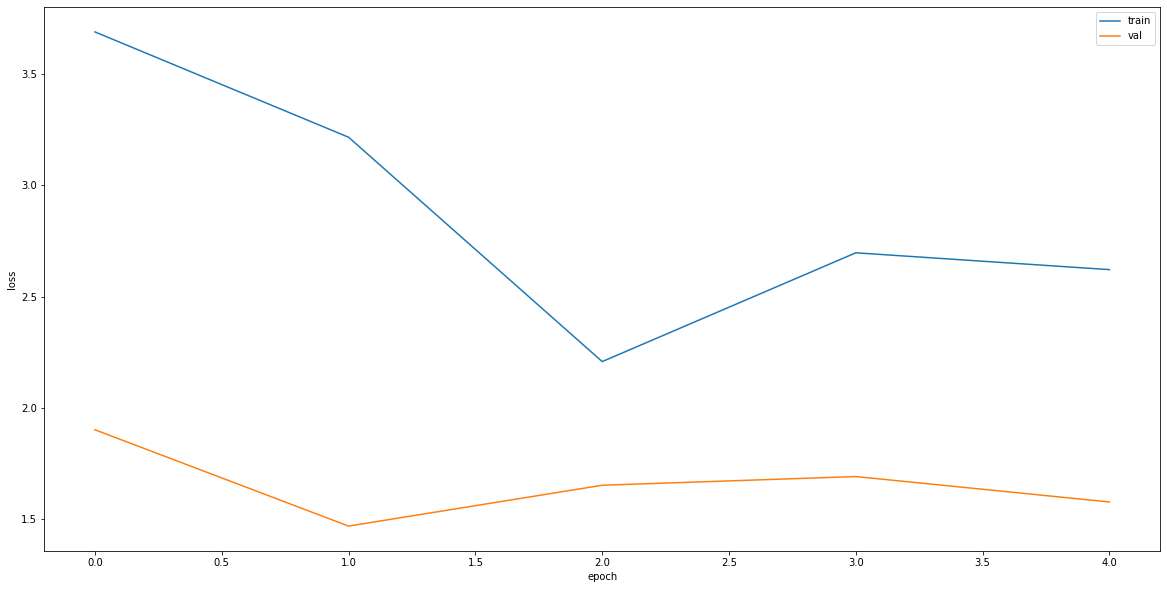

TRAINING SET
Loss: 0.4955708384513855 
Accuracy: 0.9125000238418579

TEST SET
Loss: 1.2808014154434204 
Accuracy: 0.6549999713897705


In [38]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  featurewise_center = False,            # set input mean to 0 over the dataset
  samplewise_center = False,             # set each sample mean to 0
  featurewise_std_normalization = False, # divide inputs by std of the dataset
  samplewise_std_normalization = False,  # divide each input by its std
  zca_whitening = False,                 # apply ZCA whitening
  zca_epsilon = 1e-06,                   # epsilon for ZCA whitening
  rotation_range = 5,                    # randomly rotate images in the range (degrees, 0 to 180)
  width_shift_range = 0.1,               # randomly shift images horizontally (fraction of total width)
  height_shift_range = 0.1,              # randomly shift images vertically (fraction of total height)
  shear_range = 0.,                      # set range for random shear
  zoom_range = 0.1,                      # set range for random zoom
  channel_shift_range = 0.,              # set range for random channel shifts
  fill_mode = 'nearest',                 # set mode for filling points outside the input boundaries
  cval = 0.,                             # value used for fill_mode = "constant"
  horizontal_flip = False,               # randomly flip images
  vertical_flip = False,                 # randomly flip images
  rescale = None,                        # set rescaling factor (applied before any other transformation)
  preprocessing_function = None,         # set function that will be applied on each input
  data_format = None,                    # image data format, either "channels_first" or "channels_last"
  validation_split = 0.0                 # fraction of images reserved for validation (strictly between 0 and 1)
)
datagen.fit(x_train)

# training configuration
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

#train
steps_for_epoch = np.ceil(x_train.shape[0] / batch_size)
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch = steps_for_epoch, epochs=num_epochs, validation_data=(x_val, y_val), workers=4, callbacks=[early_stop, model_save])


plt.rcParams["figure.figsize"] = (20,10)

# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x_train, y_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_test, y_test, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

##Use 50% of the images for training and 50% for testing

Epoch 1/100
7/7 [==============================] - 1s 127ms/step - loss: 4.4251 - accuracy: 0.2429 - val_loss: 0.8015 - val_accuracy: 0.8167
Epoch 2/100
7/7 [==============================] - 1s 97ms/step - loss: 4.1192 - accuracy: 0.3214 - val_loss: 0.9127 - val_accuracy: 0.7167
Epoch 3/100
7/7 [==============================] - 1s 89ms/step - loss: 3.4048 - accuracy: 0.3357 - val_loss: 0.8601 - val_accuracy: 0.6833
Epoch 4/100
7/7 [==============================] - 1s 92ms/step - loss: 3.1821 - accuracy: 0.3286 - val_loss: 0.8912 - val_accuracy: 0.7333
Epoch 4: early stopping


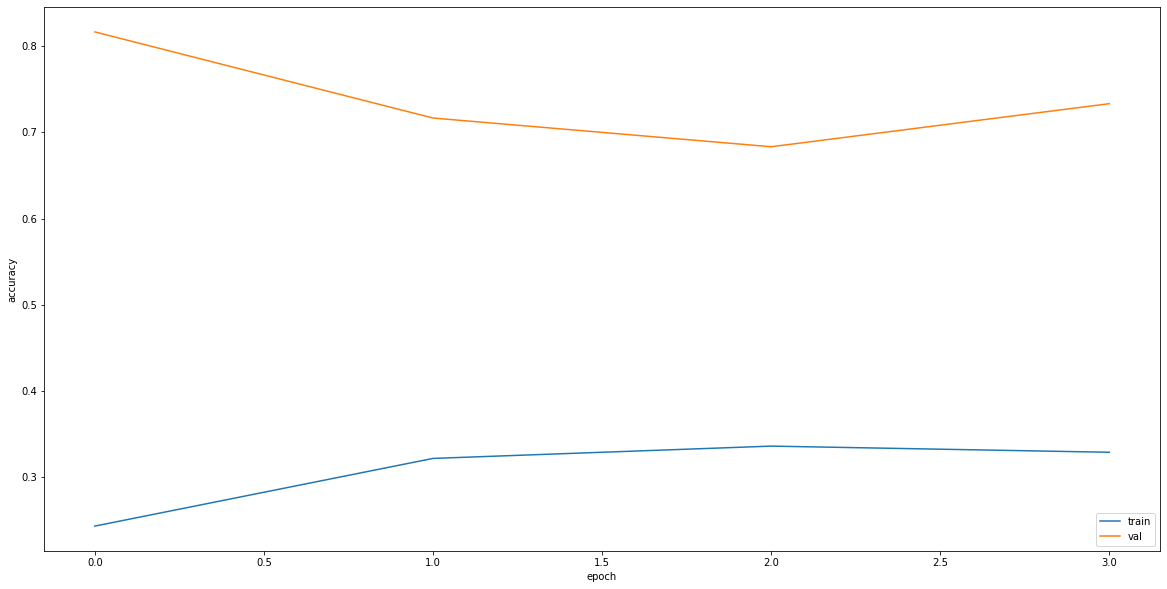

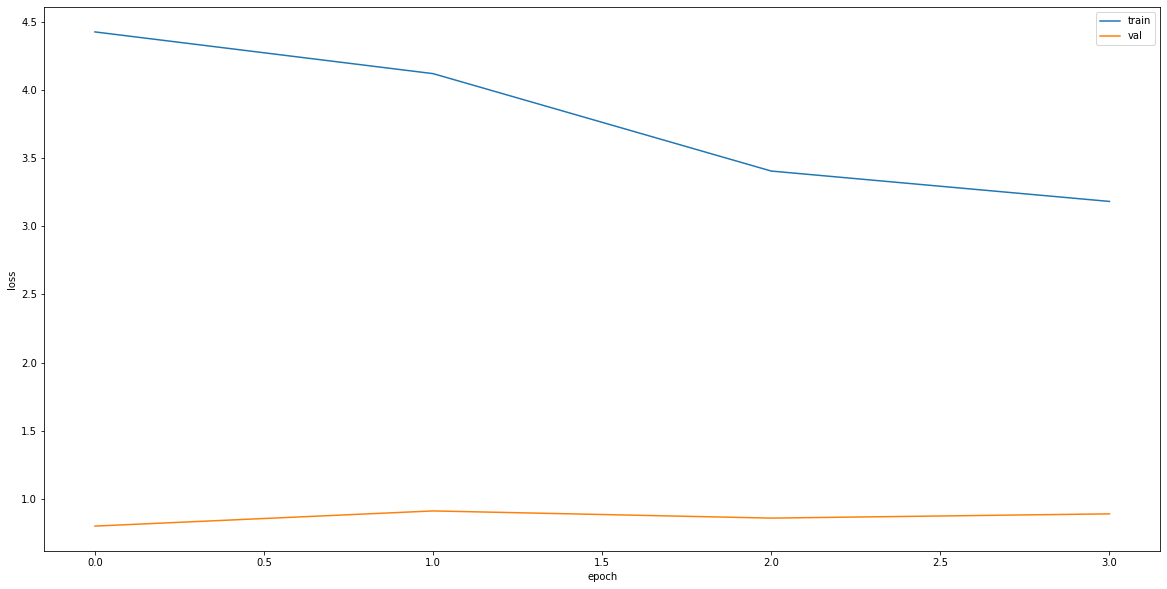

TRAINING SET
Loss: 0.6722780466079712 
Accuracy: 0.8357142806053162

TEST SET
Loss: 0.951903223991394 
Accuracy: 0.7699999809265137


In [128]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  featurewise_center = False,            # set input mean to 0 over the dataset
  samplewise_center = False,             # set each sample mean to 0
  featurewise_std_normalization = False, # divide inputs by std of the dataset
  samplewise_std_normalization = False,  # divide each input by its std
  zca_whitening = False,                 # apply ZCA whitening
  zca_epsilon = 1e-06,                   # epsilon for ZCA whitening
  rotation_range = 5,                    # randomly rotate images in the range (degrees, 0 to 180)
  width_shift_range = 0.1,               # randomly shift images horizontally (fraction of total width)
  height_shift_range = 0.1,              # randomly shift images vertically (fraction of total height)
  shear_range = 0.,                      # set range for random shear
  zoom_range = 0.1,                      # set range for random zoom
  channel_shift_range = 0.,              # set range for random channel shifts
  fill_mode = 'nearest',                 # set mode for filling points outside the input boundaries
  cval = 0.,                             # value used for fill_mode = "constant"
  horizontal_flip = False,               # randomly flip images
  vertical_flip = False,                 # randomly flip images
  rescale = None,                        # set rescaling factor (applied before any other transformation)
  preprocessing_function = None,         # set function that will be applied on each input
  data_format = None,                    # image data format, either "channels_first" or "channels_last"
  validation_split = 0.0                 # fraction of images reserved for validation (strictly between 0 and 1)
)
datagen.fit(x1_train)

# training configuration
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

#train
steps_for_epoch = np.ceil(x1_train.shape[0] / batch_size)
history = model.fit(datagen.flow(x1_train, y1_train, batch_size=batch_size), steps_per_epoch = steps_for_epoch, epochs=num_epochs, validation_data=(x1_val, y1_val), workers=4, callbacks=[early_stop, model_save])


plt.rcParams["figure.figsize"] = (20,10)

# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x1_train, y1_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x1_test, y1_test, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

##Use 80% of the images for training and 20% for testing

Epoch 1/100
13/13 [==============================] - 2s 100ms/step - loss: 4.2750 - accuracy: 0.2969 - val_loss: 1.4808 - val_accuracy: 0.5938
Epoch 2/100
13/13 [==============================] - 1s 89ms/step - loss: 2.6988 - accuracy: 0.3672 - val_loss: 1.5267 - val_accuracy: 0.6250
Epoch 3/100
13/13 [==============================] - 1s 92ms/step - loss: 2.4216 - accuracy: 0.3984 - val_loss: 1.5270 - val_accuracy: 0.6406
Epoch 4/100
13/13 [==============================] - 1s 91ms/step - loss: 2.3917 - accuracy: 0.4141 - val_loss: 1.4331 - val_accuracy: 0.6562
Epoch 5/100
13/13 [==============================] - 1s 83ms/step - loss: 2.2930 - accuracy: 0.4180 - val_loss: 1.5371 - val_accuracy: 0.6406
Epoch 6/100
13/13 [==============================] - 1s 87ms/step - loss: 2.1024 - accuracy: 0.4805 - val_loss: 1.2458 - val_accuracy: 0.7188
Epoch 7/100
13/13 [==============================] - 1s 89ms/step - loss: 2.0533 - accuracy: 0.4844 - val_loss: 1.1660 - val_accuracy: 0.7344
Epoch

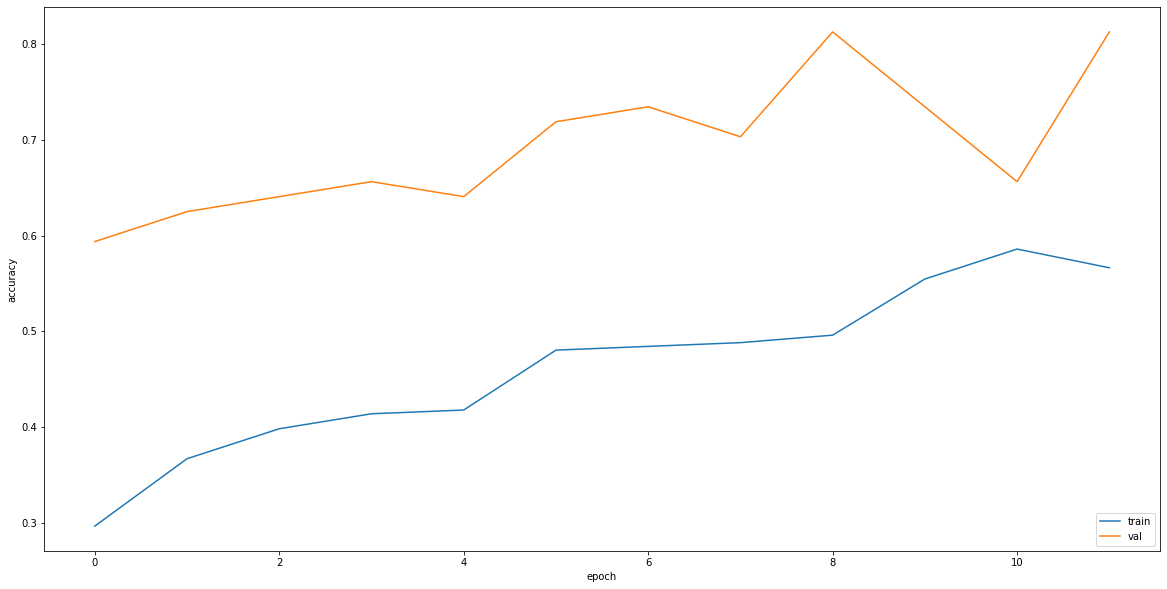

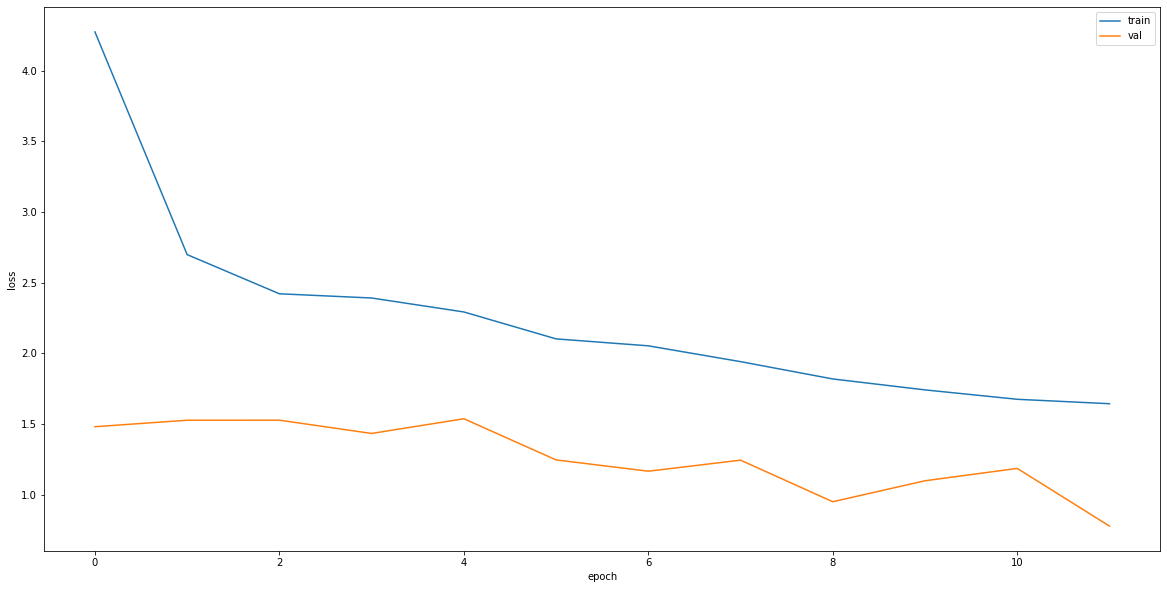

TRAINING SET
Loss: 0.37669748067855835 
Accuracy: 0.984375

TEST SET
Loss: 0.7907071709632874 
Accuracy: 0.824999988079071


In [129]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  featurewise_center = False,            # set input mean to 0 over the dataset
  samplewise_center = False,             # set each sample mean to 0
  featurewise_std_normalization = False, # divide inputs by std of the dataset
  samplewise_std_normalization = False,  # divide each input by its std
  zca_whitening = False,                 # apply ZCA whitening
  zca_epsilon = 1e-06,                   # epsilon for ZCA whitening
  rotation_range = 5,                    # randomly rotate images in the range (degrees, 0 to 180)
  width_shift_range = 0.1,               # randomly shift images horizontally (fraction of total width)
  height_shift_range = 0.1,              # randomly shift images vertically (fraction of total height)
  shear_range = 0.,                      # set range for random shear
  zoom_range = 0.1,                      # set range for random zoom
  channel_shift_range = 0.,              # set range for random channel shifts
  fill_mode = 'nearest',                 # set mode for filling points outside the input boundaries
  cval = 0.,                             # value used for fill_mode = "constant"
  horizontal_flip = False,               # randomly flip images
  vertical_flip = False,                 # randomly flip images
  rescale = None,                        # set rescaling factor (applied before any other transformation)
  preprocessing_function = None,         # set function that will be applied on each input
  data_format = None,                    # image data format, either "channels_first" or "channels_last"
  validation_split = 0.0                 # fraction of images reserved for validation (strictly between 0 and 1)
)
datagen.fit(x2_train)

# training configuration
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

#train
steps_for_epoch = np.ceil(x2_train.shape[0] / batch_size)
history = model.fit(datagen.flow(x2_train, y2_train, batch_size=batch_size), steps_per_epoch = steps_for_epoch, epochs=num_epochs, validation_data=(x2_val, y2_val), workers=4, callbacks=[early_stop, model_save])


plt.rcParams["figure.figsize"] = (20,10)

# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x2_train, y2_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x2_test, y2_test, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

# IMDB Movie Review Dataset
Description from https://www.tensorflow.org/datasets/catalog/imdb_reviews:
> Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

In [2]:
import tensorflow_datasets
import numpy as np

Load dataset

In [130]:
dataset, info = tensorflow_datasets.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Get subset of the data for training and testing (2000 samples each). Convert Keras dataset to lists of strings and labels.

In [131]:
x_train = []
y_train = []

for sample, label in train_dataset.take(2000):
  x_train.append(sample.numpy())
  y_train.append(label.numpy())

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train[0])
print(y_train[0])

x_test = []
y_test = []

for sample, label in test_dataset.take(2000):
  x_test.append(sample.numpy())
  y_test.append(label.numpy())

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_test[0])
print(y_test[0])
print("X train shape: ",x_train.shape)
print("Y train shape: ",y_train.shape)

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0
b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of th

# RNN - LTSM



In [10]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=1000)
vectorize_layer.adapt(x_train)

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=128, mask_zero=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10
32/32 [==============================] - 23s 673ms/step - loss: 0.6957 - accuracy: 0.5060 - val_loss: 0.6956 - val_accuracy: 0.4965
Epoch 2/10
32/32 [==============================] - 22s 692ms/step - loss: 0.6831 - accuracy: 0.5760 - val_loss: 0.6960 - val_accuracy: 0.4930
Epoch 3/10
32/32 [==============================] - 22s 680ms/step - loss: 0.6722 - accuracy: 0.6275 - val_loss: 0.6931 - val_accuracy: 0.5145
Epoch 4/10
32/32 [==============================] - 20s 636ms/step - loss: 0.6567 - accuracy: 0.6780 - val_loss: 0.6848 - val_accuracy: 0.5500
Epoch 5/10
32/32 [==============================] - 21s 652ms/step - loss: 0.6479 - accuracy: 0.6450 - val_loss: 0.6919 - val_accuracy: 0.5250
Epoch 6/10
32/32 [==============================] - 21s 667ms/step - loss: 0.6217 - accuracy: 0.7340 - val_loss: 0.6627 - val_accuracy: 0.6210
Epoch 7/10
32/32 [==============================] - 24s 758ms/step - loss: 0.5970 - accuracy: 0.7135 - val_loss: 0.6836 - val_accuracy: 0.5615

In [14]:
 import seaborn as sbrn
 from sklearn.metrics import confusion_matrix

63/63 [==============================] - 5s 83ms/step


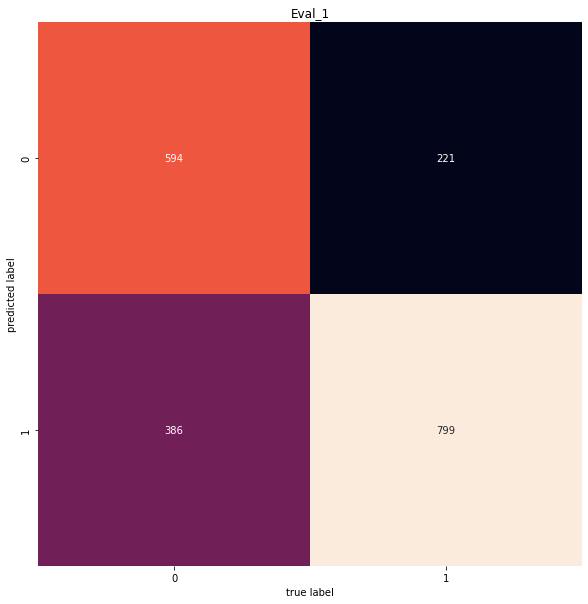

In [16]:
pre = model.predict(x_test)
for i in range(len(pre)):
    if pre[i]>=0.5:
      pre[i]=1
    elif pre[i]<0.5:
      pre[i]=0
checker = pre   

mat_1 = confusion_matrix(y_test, checker)
plt.figure(figsize=(10,10))
sbrn.heatmap(mat_1.T, square=True, annot=True, fmt='d', cbar=False)
plt.title("Eval_1")
plt.xlabel('true')
plt.ylabel('predicted');

# Add your baseline

# Report your results

I have added the plots while analyzing:

In CNN (LeNet-5) 
We see that 50% got the best accuracy and 20/80 got the worst

In CNN (LeNet-5) with data augmentation, we see 80/20 getting the worst accuracy and 20/80 getting the best.

I would say that in this case LeNet-5 was better than LDA, PCA, SVM. 

-There is a clear difference in performance for different train/test data splits. The performance of a model is affected by the quality of the data used to train and test it.

-RNN performance is very sensitive to hyperparameter selection. Even small changes in the number of hidden layers, number of neurons, learning rate, and other hyperparameters can have a large effect on the performance of the model.

